<a href="https://colab.research.google.com/github/niharkajla28/2019-scalingattack/blob/master/Spotify_working_code_with_K_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **WORKING CODE**

**Main code with graphsage, LGCN and GAT**

In [1]:
!pip install matplotlib==3.5.0

In [2]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 46.2 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 37.0 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 49.6 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.7 MB/s eta 0:00:00


In [3]:
import json
import numpy as np
import os
import torch
from torch_geometric import seed_everything
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import degree

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from sklearn.decomposition import PCA
from IPython.display import HTML

seed_everything(5) # set random seed

In [4]:
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [5]:
import matplotlib
matplotlib.__version__
assert matplotlib.__version__ == '3.5.0' # if this fails, makes sure you ran the matplotlib installation above AND restarted your runtime

In [6]:
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.2.1+cu121; Torch-cuda version: 12.1; Torch Geometric version: 2.5.3.


In [7]:
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/data_object.pt
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/dataset_stats.json
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/song_info.json
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/playlist_info.json

--2024-05-12 06:17:24--  https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/data_object.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21104811 (20M) [application/octet-stream]
Saving to: ‘data_object.pt’

data_object.pt      100%[===================>]  20.13M  --.-KB/s    in 0.1s    

2024-05-12 06:17:25 (185 MB/s) - ‘data_object.pt’ saved [21104811/21104811]

--2024-05-12 06:17:25--  https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/dataset_stats.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, a

In [8]:
# Load data
base_dir = "."
data = torch.load(os.path.join(base_dir, "data_object.pt"))
with open(os.path.join(base_dir, "dataset_stats.json"), 'r') as f:
    stats = json.load(f)
num_playlists, num_nodes = stats["num_playlists"], stats["num_nodes"]
print(data)

Data(edge_index=[2, 1318992], num_nodes=14992)


In [9]:
# Train/val/test split
transform = RandomLinkSplit(is_undirected=True, add_negative_train_samples=False, neg_sampling_ratio=0,
                            num_val=0.15, num_test=0.15)
train_split, val_split, test_split = transform(data)
# Confirm that every node appears in every set above
assert train_split.num_nodes == val_split.num_nodes and train_split.num_nodes == test_split.num_nodes

In [10]:
print(train_split)
print(val_split)
print(test_split)

Data(edge_index=[2, 923296], num_nodes=14992, edge_label=[461648], edge_label_index=[2, 461648])
Data(edge_index=[2, 923296], num_nodes=14992, edge_label=[98924], edge_label_index=[2, 98924])
Data(edge_index=[2, 1121144], num_nodes=14992, edge_label=[98924], edge_label_index=[2, 98924])


In [11]:
# note these are stored as float32, we need them to be int64 for future training

# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)
# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)

print(f"Train set has {train_split.edge_label_index.shape[1]} positives supervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 461648 positives supervision edges
Validation set has 98924 positive supervision edges
Test set has 98924 positive supervision edges
Train set has 923296 message passing edges
Validation set has 923296 message passing edges
Test set has 1121144 message passing edges


In [12]:
import torch.nn.functional as F

In [13]:
class GCN(torch.nn.Module):
    """
      Here we adapt the LightGCN model from Torch Geometric for our purposes. We allow
      for customizable convolutional layers, custom embeddings. In addition, we deifne some
      additional custom functions.

    """

    def __init__(
        self,
        num_nodes: int,
        embedding_dim: int,
        num_layers: int,
        alpha: Optional[Union[float, Tensor]] = None,
        alpha_learnable = False,
        conv_layer = "LGC",
        name = None,
        **kwargs,
    ):
        super().__init__()
        alpha_string = "alpha" if alpha_learnable else ""
        self.name = f"LGCN_{conv_layer}_{num_layers}_e{embedding_dim}_nodes{num_nodes}_{alpha_string}"
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        if alpha_learnable == True:
          alpha_vals = torch.rand(num_layers+1)
          alpha = nn.Parameter(alpha_vals/torch.sum(alpha_vals))
          print(f"Alpha learnable, initialized to: {alpha.softmax(dim=-1)}")
        else:
          if alpha is None:
              alpha = 1. / (num_layers + 1)

          if isinstance(alpha, Tensor):
              assert alpha.size(0) == num_layers + 1
          else:
              alpha = torch.tensor([alpha] * (num_layers + 1))

        self.register_buffer('alpha', alpha)

        self.embedding = Embedding(num_nodes, embedding_dim)

        # initialize convolutional layers
        self.conv_layer = conv_layer
        if conv_layer == "LGC":
          self.convs = ModuleList([LGConv(**kwargs) for _ in range(num_layers)])
        elif conv_layer == "GAT":
          # initialize Graph Attention layer with multiple heads
          # initialize linear layers to aggregate heads
          n_heads = 5
          self.convs = ModuleList(
              [GATConv(in_channels = embedding_dim, out_channels = embedding_dim, heads = n_heads, dropout = 0.5, **kwargs) for _ in range(num_layers)]
          )
          self.linears = ModuleList([Linear(n_heads * embedding_dim, embedding_dim) for _ in range(num_layers)])

        elif conv_layer == "SAGE":
          #  initialize GraphSAGE conv
          self.convs = ModuleList(
              [SAGEConv(in_channels = embedding_dim, out_channels = embedding_dim, **kwargs) for _ in range(num_layers)]
          )

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        for conv in self.convs:
            conv.reset_parameters()

    def get_embedding(self, edge_index: Adj) -> Tensor:
        x = self.embedding.weight

        weights = self.alpha.softmax(dim=-1)
        out = x * weights[0]

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            if self.conv_layer == "GAT":
              x = self.linears[i](x)
            out = out + x * weights[i + 1]

        return out

    def initialize_embeddings(self, data):
      # initialize with the data node features
        self.embedding.weight.data.copy_(data.node_feature)


    def forward(self, edge_index: Adj,
                edge_label_index: OptTensor = None) -> Tensor:
        if edge_label_index is None:
            if isinstance(edge_index, SparseTensor):
                edge_label_index = torch.stack(edge_index.coo()[:2], dim=0)
            else:
                edge_label_index = edge_index

        out = self.get_embedding(edge_index)

        return self.predict_link_embedding(out, edge_label_index)

    def predict_link(self, edge_index: Adj, edge_label_index: OptTensor = None,
                     prob: bool = False) -> Tensor:

        pred = self(edge_index, edge_label_index).sigmoid()
        return pred if prob else pred.round()

    def predict_link_embedding(self, embed: Adj, edge_label_index: Adj) -> Tensor:

        embed_src = embed[edge_label_index[0]]
        embed_dst = embed[edge_label_index[1]]
        return (embed_src * embed_dst).sum(dim=-1)


    def recommend(self, edge_index: Adj, src_index: OptTensor = None,
                  dst_index: OptTensor = None, k: int = 1) -> Tensor:
        out_src = out_dst = self.get_embedding(edge_index)

        if src_index is not None:
            out_src = out_src[src_index]

        if dst_index is not None:
            out_dst = out_dst[dst_index]

        pred = out_src @ out_dst.t()
        top_index = pred.topk(k, dim=-1).indices

        if dst_index is not None:  # Map local top-indices to original indices.
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index


    def link_pred_loss(self, pred: Tensor, edge_label: Tensor,
                       **kwargs) -> Tensor:
        loss_fn = torch.nn.BCEWithLogitsLoss(**kwargs)
        return loss_fn(pred, edge_label.to(pred.dtype))


    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,
                            lambda_reg: float = 1e-4, **kwargs) -> Tensor:
        r"""Computes the model loss for a ranking objective via the Bayesian
        Personalized Ranking (BPR) loss."""
        loss_fn = BPRLoss(lambda_reg, **kwargs)
        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)

    def bpr_loss(self, pos_scores, neg_scores):
      return - torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.num_nodes}, '
                f'{self.embedding_dim}, num_layers={self.num_layers})')


In [14]:
class BPRLoss(_Loss):
    r"""The Bayesian Personalized Ranking (BPR) loss.

    The BPR loss is a pairwise loss that encourages the prediction of an
    observed entry to be higher than its unobserved counterparts
    (see `here <https://arxiv.org/abs/2002.02126>`__).

    .. math::
        L_{\text{BPR}} = - \sum_{u=1}^{M} \sum_{i \in \mathcal{N}_u}
        \sum_{j \not\in \mathcal{N}_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj})
        + \lambda \vert\vert \textbf{x}^{(0)} \vert\vert^2

    where :math:`lambda` controls the :math:`L_2` regularization strength.
    We compute the mean BPR loss for simplicity.

    Args:
        lambda_reg (float, optional): The :math:`L_2` regularization strength
            (default: 0).
        **kwargs (optional): Additional arguments of the underlying
            :class:`torch.nn.modules.loss._Loss` class.
    """
    __constants__ = ['lambda_reg']
    lambda_reg: float

    def __init__(self, lambda_reg: float = 0, **kwargs):
        super().__init__(None, None, "sum", **kwargs)
        self.lambda_reg = lambda_reg

    def forward(self, positives: Tensor, negatives: Tensor,
                parameters: Tensor = None) -> Tensor:
        r"""Compute the mean Bayesian Personalized Ranking (BPR) loss.

        .. note::

            The i-th entry in the :obj:`positives` vector and i-th entry
            in the :obj:`negatives` entry should correspond to the same
            entity (*.e.g*, user), as the BPR is a personalized ranking loss.

        Args:
            positives (Tensor): The vector of positive-pair rankings.
            negatives (Tensor): The vector of negative-pair rankings.
            parameters (Tensor, optional): The tensor of parameters which
                should be used for :math:`L_2` regularization
                (default: :obj:`None`).
        """
        n_pairs = positives.size(0)
        log_prob = F.logsigmoid(positives - negatives).sum()
        regularization = 0

        if self.lambda_reg != 0:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)

        return (-log_prob + regularization) / n_pairs

In [15]:
def sample_negative_edges_nocheck(data, num_playlists, num_tracks, device = None):
  # note computationally inefficient to check that these are indeed negative edges
  playlists = data.edge_label_index[0, :]
  tracks = torch.randint(num_playlists, num_playlists + num_tracks - 1, size = data.edge_label_index[1, :].size())

  if playlists.get_device() != -1: # on gpu
    tracks = tracks.to(device)

  neg_edge_index = torch.stack((playlists, tracks), dim = 0)
  neg_edge_label = torch.zeros(neg_edge_index.shape[1])

  if neg_edge_index.get_device() != -1: # on gpu
    neg_edge_label = neg_edge_label.to(device)

  return neg_edge_index, neg_edge_label

def sample_negative_edges(data, num_playlists, num_tracks, device=None):
    positive_playlists, positive_tracks = data.edge_label_index

    # Create a mask tensor with the shape (num_playlists, num_tracks)
    mask = torch.zeros(num_playlists, num_tracks, device=device, dtype=torch.bool)
    mask[positive_playlists, positive_tracks - num_playlists] = True

    # Flatten the mask tensor and get the indices of the negative edges
    flat_mask = mask.flatten()
    negative_indices = torch.where(~flat_mask)[0]

    # Sample negative edges from the negative_indices tensor
    sampled_negative_indices = negative_indices[
        torch.randint(0, negative_indices.size(0), size=(positive_playlists.size(0),), device=device)
    ]

    # Convert the indices back to playlists and tracks tensors
    playlists = torch.floor_divide(sampled_negative_indices, num_tracks)
    tracks = torch.remainder(sampled_negative_indices, num_tracks)
    tracks = tracks + num_playlists

    neg_edge_index = torch.stack((playlists, tracks), dim=0)
    neg_edge_label = torch.zeros(neg_edge_index.shape[1], device=device)

    return neg_edge_index, neg_edge_label

def sample_hard_negative_edges(data, model, num_playlists, num_tracks, device=None, batch_size=500, frac_sample = 1):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:num_playlists].to(device)
        tracks_embeddings = embeddings[num_playlists:].to(device)

    positive_playlists, positive_tracks = data.edge_label_index
    num_edges = positive_playlists.size(0)

    # Create a boolean mask for all the positive edges
    positive_mask = torch.zeros(num_playlists, num_tracks, device=device, dtype=torch.bool)
    positive_mask[positive_playlists, positive_tracks - num_playlists] = True

    neg_edges_list = []
    neg_edge_label_list = []

    for batch_start in range(0, num_edges, batch_size):
        batch_end = min(batch_start + batch_size, num_edges)

        batch_scores = torch.matmul(
            playlists_embeddings[positive_playlists[batch_start:batch_end]], tracks_embeddings.t()
        )

        # Set the scores of the positive edges to negative infinity
        batch_scores[positive_mask[positive_playlists[batch_start:batch_end]]] = -float("inf")

        # Select the top k highest scoring negative edges for each playlist in the current batch
        # do 0.99 to filter out all pos edges which will be at the end
        _, top_indices = torch.topk(batch_scores, int(frac_sample * 0.99 * num_tracks), dim=1)
        selected_indices = torch.randint(0, int(frac_sample * 0.99 *num_tracks), size = (batch_end - batch_start, ))
        top_indices_selected = top_indices[torch.arange(batch_end - batch_start), selected_indices] + num_playlists

        # Create the negative edges tensor for the current batch
        neg_edges_batch = torch.stack(
            (positive_playlists[batch_start:batch_end], top_indices_selected), dim=0
        )
        neg_edge_label_batch = torch.zeros(neg_edges_batch.shape[1], device=device)

        neg_edges_list.append(neg_edges_batch)
        neg_edge_label_list.append(neg_edge_label_batch)

    # Concatenate the batch tensors
    neg_edges = torch.cat(neg_edges_list, dim=1)
    neg_edge_label = torch.cat(neg_edge_label_list)

    return neg_edges, neg_edge_label

In [16]:

def recall_at_k(data, model, k = 300, batch_size = 64, device = None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:num_playlists]
        tracks_embeddings = embeddings[num_playlists:]

    hits_list = []
    relevant_counts_list = []

    for batch_start in range(0, num_playlists, batch_size):
        batch_end = min(batch_start + batch_size, num_playlists)
        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]

        # Calculate scores for all possible item pairs
        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())

        # Set the scores of message passing edges to negative infinity
        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - num_playlists] = -float("inf")

        # Find the top k highest scoring items for each playlist in the batch
        _, top_k_indices = torch.topk(scores, k, dim=1)

        # Ground truth supervision edges
        ground_truth_edges = data.edge_label_index

        # Create a mask to indicate if the top k items are in the ground truth supervision edges
        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - num_playlists] = True

        # Check how many of the top k items are in the ground truth supervision edges
        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        # Calculate the total number of relevant items for each playlist in the batch
        relevant_counts = torch.bincount(ground_truth_edges[0, gt_indices] - batch_start, minlength=batch_end - batch_start)
        relevant_counts_list.append(relevant_counts)

    # Compute recall@k
    hits_tensor = torch.cat(hits_list, dim=0)
    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)
    # Handle division by zero case
    recall_at_k = torch.where(
        relevant_counts_tensor != 0,
        hits_tensor.true_divide(relevant_counts_tensor),
        torch.ones_like(hits_tensor)
    )
    # take average
    recall_at_k = torch.mean(recall_at_k)

    if recall_at_k.numel() == 1:
        return recall_at_k.item()
    else:
        raise ValueError("recall_at_k contains more than one item.")

In [17]:
def metrics(labels, preds):
  roc = roc_auc_score(labels.flatten().cpu().numpy(), preds.flatten().data.cpu().numpy())
  return roc

In [18]:
num_tracks = num_nodes - num_playlists

In [19]:
# Train
def train(datasets, model, optimizer, loss_fn, args, neg_samp = "random"):
  print(f"Beginning training for {model.name}")

  train_data = datasets["train"]
  val_data = datasets["val"]

  stats = {
      'train': {
        'loss': [],
        'roc' : []
      },
      'val': {
        'loss': [],
        'recall': [],
        'roc' : []
      }

  }
  val_neg_edge, val_neg_label = None, None
  for epoch in range(args["epochs"]): # loop over each epoch
    model.train()
    optimizer.zero_grad()

    # obtain negative sample
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(train_data, num_playlists, num_tracks, args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0:
        neg_edge_index, neg_edge_label = sample_hard_negative_edges(
            train_data, model, num_playlists, num_tracks, args["device"], batch_size = 500,
            frac_sample = 1 - (0.5 * epoch / args["epochs"])
        )
    # calculate embedding
    embed = model.get_embedding(train_data.edge_index)
    # calculate pos, negative scores using embedding
    pos_scores = model.predict_link_embedding(embed, train_data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)

    # concatenate pos, neg scores together and evaluate loss
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((train_data.edge_label, neg_edge_label), dim = 0)

    # calculate loss function
    if loss_fn == "BCE":
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    train_roc = metrics(labels, scores)

    loss.backward()
    optimizer.step()

    val_loss, val_roc, val_neg_edge, val_neg_label = test(
        model, val_data, loss_fn, neg_samp, epoch, val_neg_edge, val_neg_label
    )

    stats['train']['loss'].append(loss)
    stats['train']['roc'].append(train_roc)
    stats['val']['loss'].append(val_loss)
    stats['val']['roc'].append(val_roc)

    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}; Train ROC {train_roc}; Val ROC {val_roc}")

    if epoch % 10 == 0:
      # calculate recall @ K
      val_recall = recall_at_k(val_data, model, k = 300, device = args["device"])
      print(f"Val recall {val_recall}")
      stats['val']['recall'].append(val_recall)

    if epoch % 20 == 0:

      # save embeddings for future visualization
      path = os.path.join("model_embeddings", model.name)
      if not os.path.exists(path):
        os.makedirs(path)
      torch.save(model.embedding.weight, os.path.join("model_embeddings", model.name, f"{model.name}_{loss_fn}_{neg_samp}_{epoch}.pt"))

  pickle.dump(stats, open(f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pkl", "wb"))
  return stats

def test(model, data, loss_fn, neg_samp, epoch = 0, neg_edge_index = None, neg_edge_label = None):

  model.eval()
  with torch.no_grad(): # want to save RAM

    # conduct negative sampling
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(data, num_playlists, num_tracks, args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0 or neg_edge_index is None:
        neg_edge_index, neg_edge_label = sample_hard_negative_edges(
            data, model, num_playlists, num_tracks, args["device"], batch_size = 500,
            frac_sample = 1 - (0.5 * epoch / args["epochs"])
        )
    # obtain model embedding
    embed = model.get_embedding(data.edge_index)
    # calculate pos, neg scores using embedding
    pos_scores = model.predict_link_embedding(embed, data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)
    # concatenate pos, neg scores together and evaluate loss
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((data.edge_label, neg_edge_label), dim = 0)
    # calculate loss
    if loss_fn == "BCE":
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    roc = metrics(labels, scores)

  return loss, roc, neg_edge_index, neg_edge_label

In [20]:
# create a dictionary of the dataset splits
datasets = {
    'train':train_split,
    'val':val_split,
    'test': test_split
}

In [21]:
# initialize our arguments
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' :  3,
    'emb_size' : 64,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 301
}

In [22]:
# initialize model and and optimizer
num_nodes = num_playlists + num_tracks
model = GCN(
    num_nodes = num_nodes, num_layers = args['num_layers'],
    embedding_dim = args["emb_size"], conv_layer = "SAGE"
)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [23]:
# send data, model to GPU if available
# playlists_idx = torch.Tensor(playlists_idx).type(torch.int64).to(args["device"])
# tracks_idx =torch.Tensor(tracks_idx).type(torch.int64).to(args["device"])
datasets['train'].to(args['device'])
datasets['val'].to(args['device'])
datasets['test'].to(args['device'])
model.to(args["device"])

GCN(14992, 64, num_layers=3)

In [24]:
# create directory to save model_stats
MODEL_STATS_DIR = "model_stats"
if not os.path.exists(MODEL_STATS_DIR):
  os.makedirs(MODEL_STATS_DIR)

In [25]:
train(datasets, model, optimizer, "BPR", args, neg_samp = "random")

Beginning training for LGCN_SAGE_3_e64_nodes14992_
Epoch 0; Train loss 0.6931582689285278; Val loss 0.690915048122406; Train ROC 0.49665699692963405; Val ROC 0.7019578601541678
Val recall 0.1489275097846985
Epoch 1; Train loss 0.6908258199691772; Val loss 0.6717551350593567; Train ROC 0.7097657771460729; Val ROC 0.7029736885715335
Epoch 2; Train loss 0.6706168055534363; Val loss 0.605961263179779; Train ROC 0.712350994202342; Val ROC 0.6952539171675249
Epoch 3; Train loss 0.6016038656234741; Val loss 0.6801906228065491; Train ROC 0.7019460855564329; Val ROC 0.6939060626905366
Epoch 4; Train loss 0.6653987765312195; Val loss 0.5573788285255432; Train ROC 0.7010793919882705; Val ROC 0.7133282474526794
Epoch 5; Train loss 0.5458967089653015; Val loss 0.5739343166351318; Train ROC 0.7231849152438555; Val ROC 0.7105958354484526
Epoch 6; Train loss 0.5636099576950073; Val loss 0.5821048021316528; Train ROC 0.72315132138001; Val ROC 0.7062640096864444
Epoch 7; Train loss 0.574537456035614; Va

{'train': {'loss': [tensor(0.6932, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6908, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6706, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6016, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.6654, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5459, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5636, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5745, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5727, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5697, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5668, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5552, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5418, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5349, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5381, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5363, device='cuda:0', grad_fn=<DivBackward0>),
   tensor(0.5343, devic

In [26]:
test(model, datasets['test'], "BPR", neg_samp = "random")


(tensor(0.2125, device='cuda:0'),
 0.9110947401966392,
 tensor([[ 8803,  1092,  2734,  ...,  9089,  4277,  8218],
         [13593, 11970, 10024,  ..., 12398, 10168, 12686]], device='cuda:0'),
 tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'))

In [27]:
def init_model(conv_layer, args, alpha = False):
  num_nodes = num_playlists + num_tracks
  model = GCN(
      num_nodes = num_nodes, num_layers = args['num_layers'],
      embedding_dim = args["emb_size"], conv_layer = conv_layer,
      alpha_learnable = alpha
  )
  model.to(args["device"])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
  return model, optimizer

In [28]:
## For example:

# using BPR loss
loss_fn = "BPR"

# using hard sampling
neg_samp = "hard"

# for LGConv:
args['epochs'] = 301
args['num_layers'] = 4
model, optimizer = init_model("LGC", args)
lgc_stats_hard = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_LGC_4_e64_nodes14992_
Epoch 0; Train loss 0.6931412220001221; Val loss 0.6931411027908325; Train ROC 0.5747346061625932; Val ROC 0.6883203932802254
Val recall 0.21506182849407196
Epoch 1; Train loss 0.6931393146514893; Val loss 0.693065881729126; Train ROC 0.7599794353291259; Val ROC 0.7965365992194324
Epoch 2; Train loss 0.693062961101532; Val loss 0.6925933361053467; Train ROC 0.8079085501162235; Val ROC 0.7919059856364539
Epoch 3; Train loss 0.6925756931304932; Val loss 0.6911971569061279; Train ROC 0.800503351544273; Val ROC 0.7950707897066241
Epoch 4; Train loss 0.6911348104476929; Val loss 0.6884030103683472; Train ROC 0.8030457798378798; Val ROC 0.7979899022405101
Epoch 5; Train loss 0.6883031129837036; Val loss 0.6840824484825134; Train ROC 0.8046142731169574; Val ROC 0.7965932846775856
Epoch 6; Train loss 0.6836482882499695; Val loss 0.6776665449142456; Train ROC 0.8066577824572383; Val ROC 0.7978729823103213
Epoch 7; Train loss 0.6769216060638428; 

In [29]:
# for GATConv:
args['epochs'] = 301
args['num_layers'] = 3
model, optimizer = init_model("GAT", args)
gat_stats_hard = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_GAT_3_e64_nodes14992_
Epoch 0; Train loss 0.693152666091919; Val loss 0.6929080486297607; Train ROC 0.4929043132731181; Val ROC 0.6742363875901523
Val recall 0.15112146735191345
Epoch 1; Train loss 0.692891001701355; Val loss 0.6904889941215515; Train ROC 0.6780525414116442; Val ROC 0.6894078299158195
Epoch 2; Train loss 0.6903257369995117; Val loss 0.6584977507591248; Train ROC 0.6822562271114672; Val ROC 0.6315472587320102
Epoch 3; Train loss 0.6669867038726807; Val loss 0.6326902508735657; Train ROC 0.5691074674452313; Val ROC 0.6053169713267728
Epoch 4; Train loss 0.6308123469352722; Val loss 2.4833571910858154; Train ROC 0.6042863943103355; Val ROC 0.6007189516408149
Epoch 5; Train loss 2.5607893466949463; Val loss 0.6357485055923462; Train ROC 0.5978129663342915; Val ROC 0.6315430084582044
Epoch 6; Train loss 0.6325622200965881; Val loss 0.6815922260284424; Train ROC 0.6338183516548133; Val ROC 0.6285893272078227
Epoch 7; Train loss 0.6805570125579834;

In [30]:
# for SAGEConv:
args['epochs'] = 301
args['num_layers'] = 3
model, optimizer = init_model("SAGE", args)
sage_stats_hard = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_SAGE_3_e64_nodes14992_
Epoch 0; Train loss 0.6931357383728027; Val loss 0.6902198195457458; Train ROC 0.5039309030438832; Val ROC 0.6702253851008236
Val recall 0.14446139335632324
Epoch 1; Train loss 0.6900226473808289; Val loss 0.6700016856193542; Train ROC 0.6806999797443902; Val ROC 0.6655765921015763
Epoch 2; Train loss 0.6684571504592896; Val loss 0.6029742956161499; Train ROC 0.6740473825073502; Val ROC 0.6568081494550688
Epoch 3; Train loss 0.595016598701477; Val loss 0.746614396572113; Train ROC 0.6650916878467807; Val ROC 0.6500583043186021
Epoch 4; Train loss 0.7145593166351318; Val loss 0.5784186124801636; Train ROC 0.6588136054346784; Val ROC 0.6649598396959199
Epoch 5; Train loss 0.5692369937896729; Val loss 0.596264123916626; Train ROC 0.6694356285609625; Val ROC 0.6682420795374582
Epoch 6; Train loss 0.5889678001403809; Val loss 0.6202802062034607; Train ROC 0.6759603759635641; Val ROC 0.669457640831742
Epoch 7; Train loss 0.6138957142829895; 

In [31]:
# using random sampling
neg_samp = "random"

# for LGConv:
args['epochs'] = 301
args['num_layers'] = 4
model, optimizer = init_model("LGC", args)
lgc_stats = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_LGC_4_e64_nodes14992_
Epoch 0; Train loss 0.6931413412094116; Val loss 0.6931418180465698; Train ROC 0.5722241984794135; Val ROC 0.6779020604676682
Val recall 0.19331569969654083
Epoch 1; Train loss 0.6931403875350952; Val loss 0.6930764317512512; Train ROC 0.7418104908957658; Val ROC 0.797329724499314
Epoch 2; Train loss 0.6930736899375916; Val loss 0.6926478147506714; Train ROC 0.8103531405134378; Val ROC 0.7886718050662473
Epoch 3; Train loss 0.6926310062408447; Val loss 0.6913290619850159; Train ROC 0.7977071473485056; Val ROC 0.7892872243882856
Epoch 4; Train loss 0.691264271736145; Val loss 0.6886069178581238; Train ROC 0.7990141824964644; Val ROC 0.7934704898832992
Epoch 5; Train loss 0.6884730458259583; Val loss 0.6841458082199097; Train ROC 0.8010441115849365; Val ROC 0.7945093027652564
Epoch 6; Train loss 0.6838672161102295; Val loss 0.6776069402694702; Train ROC 0.8027225977747807; Val ROC 0.7959903957079979
Epoch 7; Train loss 0.6771116852760315;

In [32]:
# for GATConv:
args['epochs'] = 301
args['num_layers'] = 3
model, optimizer = init_model("GAT", args)
gat_stats = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_GAT_3_e64_nodes14992_
Epoch 0; Train loss 0.693146824836731; Val loss 0.6924689412117004; Train ROC 0.5001356608882126; Val ROC 0.7103784053257497
Val recall 0.1588776856660843
Epoch 1; Train loss 0.6924359798431396; Val loss 0.6861427426338196; Train ROC 0.7148546258151534; Val ROC 0.7124579685597041
Epoch 2; Train loss 0.6858956217765808; Val loss 0.7207730412483215; Train ROC 0.6886883637825403; Val ROC 0.6197750317679277
Epoch 3; Train loss 0.8824587464332581; Val loss 0.6798057556152344; Train ROC 0.5811521025162061; Val ROC 0.702628948222431
Epoch 4; Train loss 0.6793364882469177; Val loss 0.6882597804069519; Train ROC 0.6872594557883127; Val ROC 0.6941536674784852
Epoch 5; Train loss 0.6879937648773193; Val loss 0.6890562772750854; Train ROC 0.7032653552917268; Val ROC 0.68513135954287
Epoch 6; Train loss 0.6888365149497986; Val loss 0.6869120001792908; Train ROC 0.694678840912192; Val ROC 0.6275484212246615
Epoch 7; Train loss 0.6866023540496826; Val

In [33]:
# for SAGEConv:
args['epochs'] = 301
args['num_layers'] = 3
model, optimizer = init_model("SAGE", args)
sage_stats = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_SAGE_3_e64_nodes14992_
Epoch 0; Train loss 0.6931430101394653; Val loss 0.6904933452606201; Train ROC 0.5020046707626801; Val ROC 0.7030076348144668
Val recall 0.14192144572734833
Epoch 1; Train loss 0.6903724670410156; Val loss 0.6710484623908997; Train ROC 0.7120177586280705; Val ROC 0.707758091393588
Epoch 2; Train loss 0.6702101826667786; Val loss 0.6063061952590942; Train ROC 0.7143234438632037; Val ROC 0.6958516305578631
Epoch 3; Train loss 0.6003300547599792; Val loss 0.6761971712112427; Train ROC 0.7051388191240898; Val ROC 0.6926331600493102
Epoch 4; Train loss 0.6594009399414062; Val loss 0.5586335062980652; Train ROC 0.7010801973369253; Val ROC 0.7132831578446819
Epoch 5; Train loss 0.5459645986557007; Val loss 0.572039008140564; Train ROC 0.7234873776945725; Val ROC 0.7130441122087262
Epoch 6; Train loss 0.5621442794799805; Val loss 0.5805424451828003; Train ROC 0.724851494963711; Val ROC 0.7070919734060378
Epoch 7; Train loss 0.5721893310546875;

In [34]:
def detach_loss(stats):
  return [loss.detach().cpu().numpy().item() for loss in stats]

def plot_train_val_loss(stats_dict):
  fig, ax = plt.subplots(1,1, figsize = (6, 4))
  train_loss = detach_loss(stats_dict["train"]["loss"])
  val_loss = detach_loss(stats_dict["val"]["loss"])
  idx = np.arange(0, len(train_loss), 1)
  ax.plot(idx, train_loss, label = "train")
  ax.plot(idx, val_loss, label = "val")
  ax.legend()
  plt.show()

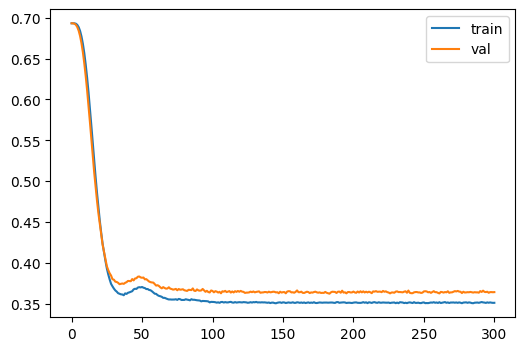

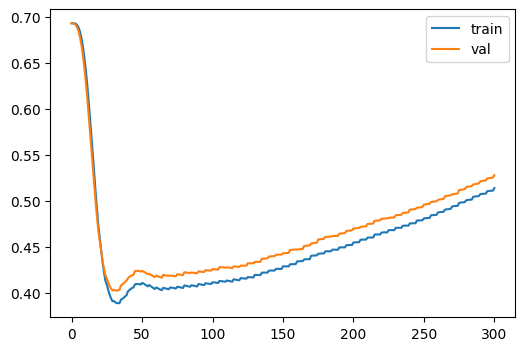

In [35]:
plot_train_val_loss(lgc_stats)
plot_train_val_loss(lgc_stats_hard)

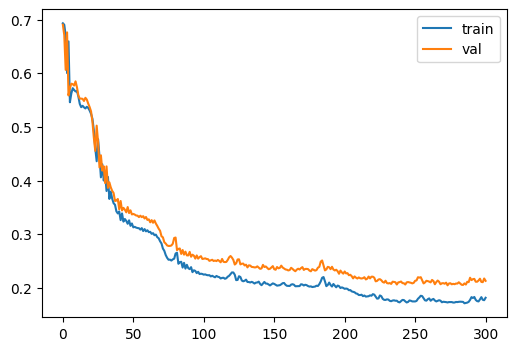

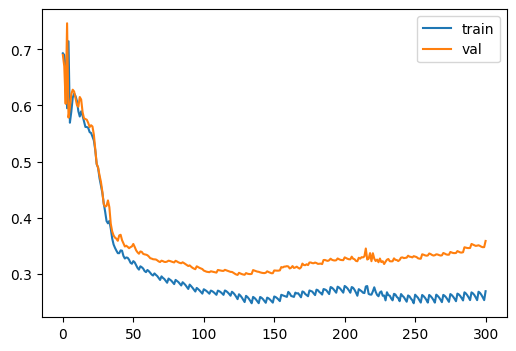

In [36]:
plot_train_val_loss(sage_stats)
plot_train_val_loss(sage_stats_hard)

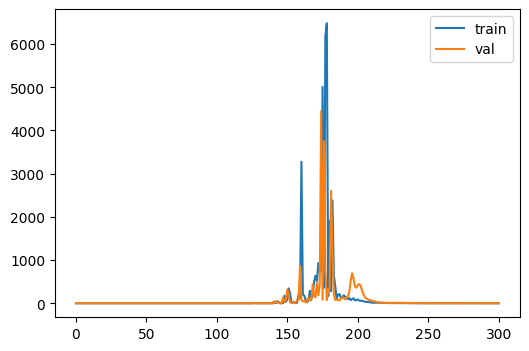

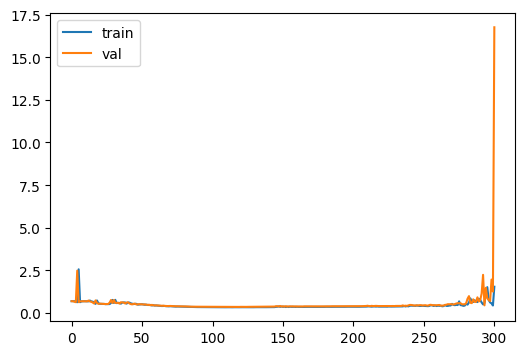

In [37]:
plot_train_val_loss(gat_stats)
plot_train_val_loss(gat_stats_hard)

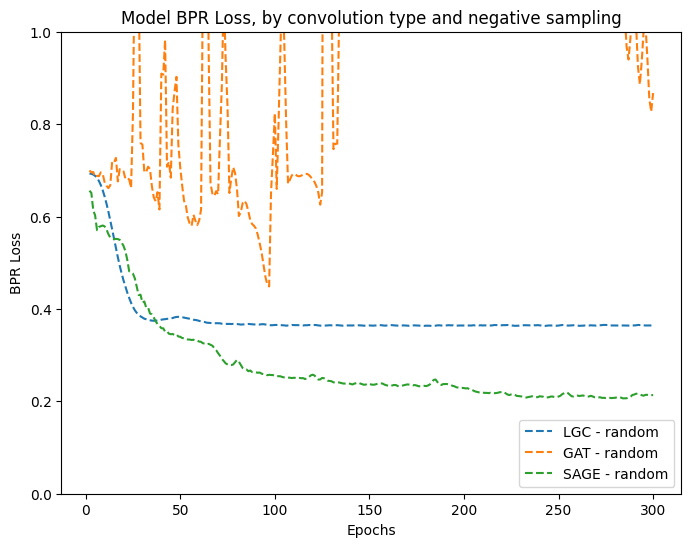

In [38]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "loss"
lgc_loss = pd.Series(detach_loss(lgc_stats["val"][key])).rolling(3).mean()
lgc_loss_np = lgc_loss.to_numpy()
gat_loss = pd.Series(detach_loss(gat_stats["val"][key])).rolling(3).mean()
gat_loss_np = gat_loss.to_numpy()
sage_loss = pd.Series(detach_loss(sage_stats["val"][key])).rolling(3).mean()
sage_loss_np = sage_loss.to_numpy()
idx = np.arange(0, len(lgc_loss), 1)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_loss_np, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, gat_loss_np, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx, sage_loss_np, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("BPR Loss")
ax.set_title("Model BPR Loss, by convolution type and negative sampling")
ax.set_ylim(0, 1)
plt.show()

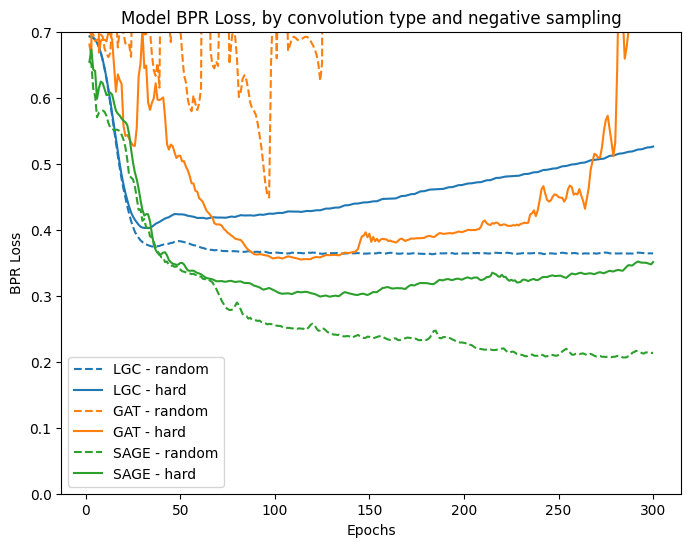

In [39]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "loss"
lgc_loss = pd.Series(detach_loss(lgc_stats["val"][key])).rolling(3).mean()
lgc_loss_np = lgc_loss.to_numpy()
gat_loss = pd.Series(detach_loss(gat_stats["val"][key])).rolling(3).mean()
gat_loss_np = gat_loss.to_numpy()
sage_loss = pd.Series(detach_loss(sage_stats["val"][key])).rolling(3).mean()
sage_loss_np = sage_loss.to_numpy()
lgc_hard_loss = pd.Series(detach_loss(lgc_stats_hard["val"][key])).rolling(3).mean()
lgc_hard_loss_np = lgc_hard_loss.to_numpy()
gat_hard_loss = pd.Series(detach_loss(gat_stats_hard["val"][key])).rolling(3).mean()
gat_hard_loss_np = gat_hard_loss.to_numpy()
sage_hard_loss = pd.Series(detach_loss(sage_stats_hard["val"][key])).rolling(3).mean()
sage_hard_loss_np = sage_hard_loss.to_numpy()
idx = np.arange(0, len(lgc_loss), 1)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_loss_np, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, lgc_hard_loss_np, color = colors[0], label = "LGC - hard")
ax.plot(idx, gat_loss_np, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx, gat_hard_loss_np, color = colors[1], label = "GAT - hard")
ax.plot(idx, sage_loss_np, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.plot(idx, sage_hard_loss_np, color = colors[2], label = "SAGE - hard")
ax.legend(loc = 'lower left')

ax.set_xlabel("Epochs")
ax.set_ylabel("BPR Loss")
ax.set_title("Model BPR Loss, by convolution type and negative sampling")
ax.set_ylim(0, 0.7)
plt.show()

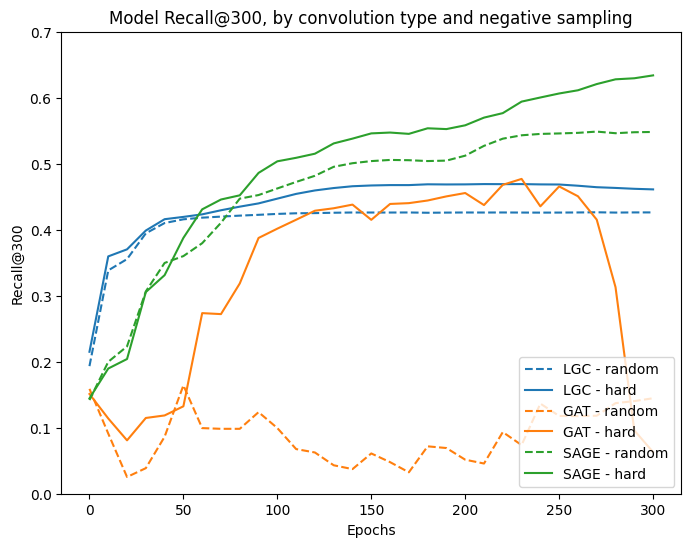

In [40]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "recall"
lgc_recall = lgc_stats["val"][key]
gat_recall = gat_stats["val"][key]
sage_recall = sage_stats["val"][key]
lgc_hard_recall = lgc_stats_hard["val"][key]
gat_hard_recall = gat_stats_hard["val"][key]
sage_hard_recall = sage_stats_hard["val"][key]
# increment by 10
idx = np.arange(0, 10 * len(lgc_recall), 10)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_recall, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, lgc_hard_recall, color = colors[0], label = "LGC - hard")
ax.plot(idx, gat_recall, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx, gat_hard_recall, color = colors[1], label = "GAT - hard")
ax.plot(idx, sage_recall, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.plot(idx, sage_hard_recall, color = colors[2], label = "SAGE - hard")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("Recall@300")
ax.set_title("Model Recall@300, by convolution type and negative sampling")
ax.set_ylim(0, 0.7)
plt.show()